<a href="https://colab.research.google.com/github/poojatambe/VGG-Image-classification/blob/main/vgg19_with_and_without_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import libraries

In [ ]:
!pip install livelossplot

In [1]:
from keras.applications.vgg19 import VGG19
import os
import glob
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Model
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from livelossplot.inputs.keras import PlotLossesCallback

In [2]:
!nvidia-smi

Sun May  8 16:05:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Data preparation

In [ ]:
!unzip '/content/drive/MyDrive/vgg/seg_test.zip' -d '/content'
!unzip '/content/drive/MyDrive/vgg/seg_train.zip' -d '/content'

                          class  no_img
0        /content/seg_train/sea    1242
1  /content/seg_train/buildings    1183
2   /content/seg_train/mountain    1480
3     /content/seg_train/forest    1239
4    /content/seg_train/glacier    1372
5     /content/seg_train/street    1350
                         class  no_img
0        /content/seg_test/sea     510
1  /content/seg_test/buildings     437
2   /content/seg_test/mountain     525
3     /content/seg_test/forest     474
4    /content/seg_test/glacier     553
5     /content/seg_test/street     501


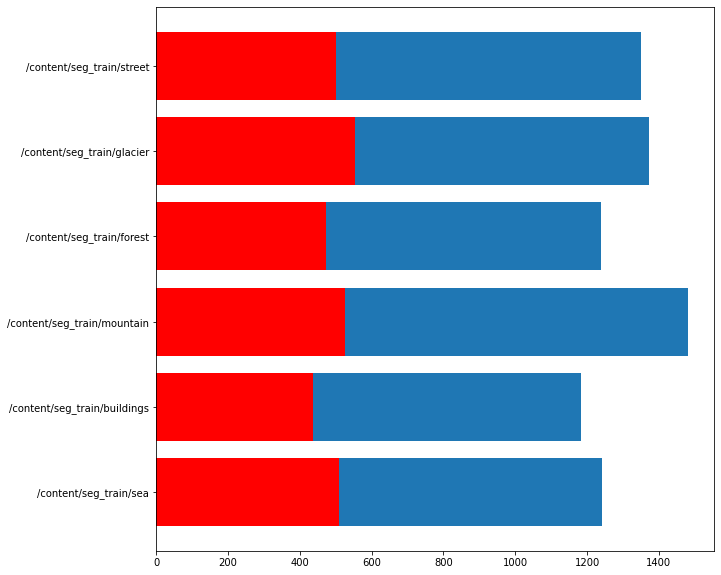

In [4]:
no_traindata={}
no_testdata={}

# train and test directories
train_1= glob.glob('/content/seg_train/*')
test_1= glob.glob('/content/seg_test/*')

for i in train_1:
    #print(glob.glob(str(i)+"\*")[0:5])
    no_traindata[i]= len(glob.glob(str(i)+"/*"))

#print(no_traindata)

for i in test_1:
    #print(glob.glob(str(i)+"\*")[0:5])
    no_testdata[i]= len(glob.glob(str(i)+"/*"))

#print(no_testdata)

train_df= pd.DataFrame(no_traindata.items(), columns=['class', 'no_img'])
print(train_df)

test_df= pd.DataFrame(no_testdata.items(), columns=['class', 'no_img'])
print(test_df)

#visualise data
plt.figure(figsize=(10,10))
plt.barh(train_df['class'], train_df['no_img'], label='train')
plt.barh(train_df['class'], test_df['no_img'], color='r', label='test')
plt.show()

In [5]:
#  data augmentation using ImageDataGenerator
BATCH_SIZE = 64


train_generator = ImageDataGenerator(rotation_range=90, 
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5, 
                                     height_shift_range=0.5,
                                     horizontal_flip=True, 
                                     vertical_flip=True,
                                     validation_split=0.15,
                                     preprocessing_function=preprocess_input) # VGG19 preprocessing

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input) # VGG19 preprocessing


#data preparation
traingen = train_generator.flow_from_directory('/content/seg_train',
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               subset='training',
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

validgen = train_generator.flow_from_directory('/content/seg_train',
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

testgen = test_generator.flow_from_directory('/content/seg_test',
                                             target_size=(224, 224),
                                             class_mode=None,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)

Found 6689 images belonging to 6 classes.
Found 1177 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


# Classification model function



*  Pre-trained Vgg 19 model is used as base model. Using Include_top=False, last fully connected layers are excluded.
*   Output of the base model is given to dense layers which are specified according to new dataset.

*   the fine_tune parameter is used to freeze layers of the base model.





In [6]:
# transfer learning without fine tuning
def model(input_shape, n_classes, optimizer='adam', fine_tune=0):
    """
    Complies a model integrated with vgg16 pretrained layers

    Parameters
    ------------------------
    input_shape: tuple
    shape of input images (width, height, channels)
    n_classes: int
    Number of classes for output layer
    optimizer: string
    Instantiated optimizer for training, default to adam
    fine_tune: int
    No of pretrained layers to unfreeze.
    If set to 0, all layers will freeze during training

    Return
    -------------------------------
    model: compiled model

    """
    
    # pretrained layers are added. Include_top is set to false, in order to exclude model's fully connected layers.
    conv_base = VGG19(weights='imagenet',
                    include_top= False,
                    input_shape=input_shape)
    
    # Defines how many layers to freeze.
    # Layers in conv_base are changed from trainable to non-trainable based on fine_tune value. 
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False

    else:
        for layer in conv_base.layers:
            layer.trainable =False
                
    # create fully-connected layers
    top_model= conv_base.output
    top_model= Flatten(name='flatten')(top_model)                
    top_model= Dense(4096, activation='relu')(top_model)
    top_model= Dense(1072, activation='relu')(top_model)
    top_model= Dropout(0.2)(top_model)
    output_layer= Dense(n_classes, activation='softmax')(top_model)

    # group pretrained layers and fully connected layers.
    model= Model(inputs= conv_base.input, outputs= output_layer)

    #complies model 
    model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    
    return model

In [ ]:

# Model without fine tuning
input_shape = (224, 224, 3)
optim_1 = Adam(learning_rate=0.0001)
n_classes=6

n_steps = traingen.samples // BATCH_SIZE
n_val_steps = validgen.samples // BATCH_SIZE
n_epochs = 10
print('Steps', n_steps, n_val_steps)

# First we'll train the model without Fine-tuning
vgg_model = model(input_shape, n_classes, optim_1, fine_tune=0)

# summary of the model
vgg_model.summary()

Steps 104 18
80150528/80134624 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                 

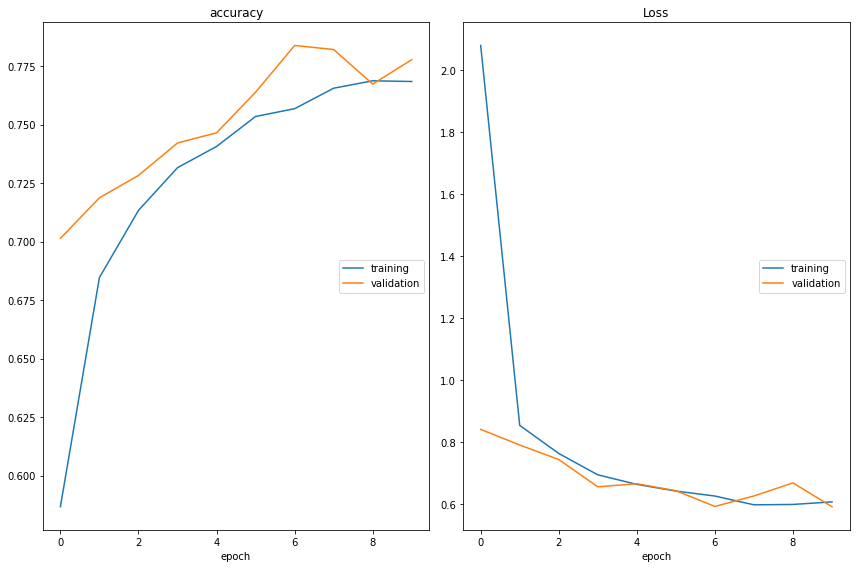

accuracy
	training         	 (min:    0.587, max:    0.769, cur:    0.768)
	validation       	 (min:    0.701, max:    0.784, cur:    0.778)
Loss
	training         	 (min:    0.597, max:    2.079, cur:    0.606)
	validation       	 (min:    0.590, max:    0.840, cur:    0.590)
104/104 [==============================] - 154s 1s/step - loss: 0.6061 - accuracy: 0.7685 - val_loss: 0.5905 - val_accuracy: 0.7778


In [ ]:


# callbacks

plot_loss_1 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='/content/drive/MyDrive/vgg/model_feature19.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=3,
                           restore_best_weights=True,
                           mode='min')
# tensorboard
#tb_callback= tf.keras.callbacks.TensorBoard(log_dir='logs')


# model training
vgg_history = vgg_model.fit(traingen,
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            validation_data=validgen,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_1, early_stop, plot_loss_1],
                            verbose=1)                           

    



In [ ]:
# Load the TensorBoard notebook extension
#%load_ext tensorboard
#%tensorboard --logdir logs

In [ ]:
# Generate predictions
vgg_model.load_weights('/content/drive/MyDrive/vgg/model_feature19.weights.best.hdf5') # initialize the best trained weights

true_classes = testgen.classes
class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

vgg_preds = vgg_model.predict(testgen)
vgg_pred_classes = np.argmax(vgg_preds, axis=1)

In [ ]:
from sklearn.metrics import accuracy_score

vgg_acc = accuracy_score(true_classes, vgg_pred_classes)
print("VGG19 Model Accuracy without Fine-Tuning: {:.2f}%".format(vgg_acc * 100))

VGG19 Model Accuracy without Fine-Tuning: 87.30%


# Fine tuning
The fine_tune is set to 2, which unfreezes last 2 layers and these layers are used in training model on new data. 

In [7]:
# Reset our image data generators
traingen.reset()
validgen.reset()
testgen.reset()

n_steps = traingen.samples // BATCH_SIZE
n_val_steps = validgen.samples // BATCH_SIZE
n_epochs = 10
print('Steps', n_steps, n_val_steps)


input_shape = (224, 224, 3)
n_classes= 6
# Use a smaller learning rate
optim_2 = Adam(learning_rate=0.0001)

# Re-compile the model, this time leaving the last 2 layers unfrozen for Fine-Tuning
vgg_model_ft = model(input_shape, n_classes, optim_2, fine_tune=2)

#model summary
vgg_model_ft.summary()

Steps 104 18
80150528/80134624 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                 

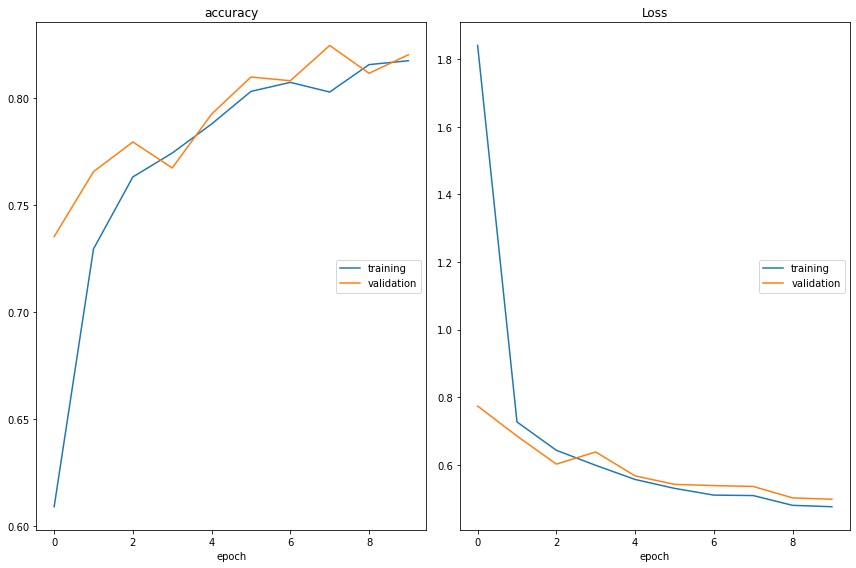

accuracy
	training         	 (min:    0.609, max:    0.818, cur:    0.818)
	validation       	 (min:    0.735, max:    0.825, cur:    0.820)
Loss
	training         	 (min:    0.476, max:    1.840, cur:    0.476)
	validation       	 (min:    0.498, max:    0.774, cur:    0.498)
104/104 [==============================] - 129s 1s/step - loss: 0.4758 - accuracy: 0.8175 - val_loss: 0.4979 - val_accuracy: 0.8203


In [8]:
# callbacks

plot_loss_2 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='/content/drive/MyDrive/vgg/tune_model19.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=3,
                           restore_best_weights=True,
                           mode='min')

# tensorboard
#tb_callback= tf.keras.callbacks.TensorBoard(log_dir='logs/tune')

# Retrain model with fine-tuning
vgg_ft_history = vgg_model_ft.fit(traingen,
                                  batch_size=BATCH_SIZE,
                                  epochs=n_epochs,
                                  validation_data=validgen,
                                  steps_per_epoch=n_steps, 
                                  validation_steps=n_val_steps,
                                  callbacks=[tl_checkpoint_1, early_stop,plot_loss_2],
                                  verbose=1)

In [9]:
# Generate predictions
vgg_model_ft.load_weights('/content/drive/MyDrive/vgg/tune_model19.weights.best.hdf5') # initialize the best trained weights

true_classes = testgen.classes
class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

vgg_preds_ft = vgg_model_ft.predict(testgen)
vgg_pred_classes_ft = np.argmax(vgg_preds_ft, axis=1)

In [10]:
from sklearn.metrics import accuracy_score

vgg_acc = accuracy_score(true_classes, vgg_pred_classes_ft)
print("VGG16 Model Accuracy with Fine-Tuning: {:.2f}%".format(vgg_acc * 100))

VGG16 Model Accuracy with Fine-Tuning: 88.10%
